In [ ]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# # Load fonts
# font_path = r"C:"
# fm.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Helvetica'

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [2]:
"""Running.ipynb
Filter for all running attempts
    Using Contests.ipynb
Get smoothed running data (running_smooth.csv)
    - Speed/Acceleration towards 1st base at each 100ms interval
      (& ft_til_1st)
      (smoothed)
Get running data (contest_running.csv): 
    - Contact timestamp
    - Batter handedness
    - Time to start running
    - Time out of the box
    - Player-specific run signature (top speed/acceleration)
      (MAP estimation)
      (Variance reduction using Z-scores)
Get E[max_acceleration|effort;speed] (max_acc_cap_models)
    - Infer effort level at each interval (intent)

1. Filter play_id's for contests at 1st base
    Using contest_results.csv (Contests.ipynb)
2. Label batter_id to each play_id
    Using game_events, game_info
3. Get contact_timestamp, handedness
    Using player_pos, game_events
4. Calculate ft_til_1st at each timestamp interval
    Using player_pos   
6. Calculate speed/acceleration towards 1st base at each 100ms interval
    (Speed = Distance/Time_delta, i.e. velocity)
    (Acceleration = Velocity_delta/Time_delta)
7. Smooth the position data
    Use cubic interpolation
    Calculate speed/acceleration again
X. (Export)
8. Filter by time_start_running
9. Reliably estimate maximum speed
    ((Soft) MAP estimation)
10. Reliably estimate 95th percentile acceleration
    (Use 95th percentile for more reliability)
    (Variance reduction using z-scores)
11. Combine & Analyze
12. Fit ML model for maximum acceleration at given speed & runner signature
    (Evaluate)
13. Investigate acceleration at effort levels
    Using studies
    (Polynomial Fit)
14. Infer effort level (intent)
    Calculate Hustle+
    
"""
pass

In [3]:
"""
Filter play_id's for contests at 1st base
    Using contest_results.csv (Contests.ipynb)
"""
contest_results = pd.read_csv('../CSV/contest_results.csv')
contest_results = contest_results[['game_str','play_id']]
contest_results.head(1)

,game_str,play_id
0,y1_d001_CGA_QEA,21


In [4]:
"""
Label batter_id to each play_id
    Using game_events, game_info
    1. Get play_per_game number
    2. Filter game_events with contests at 1st base
    3. Match game_events with game_info
    4. Fill game_info with ad_hoc play_per_game and match again
"""
## 1. Get play_per_game number
ge_df = game_events_subset.to_table(
    filter=pads.field('player_position')==10,columns=['game_str','play_id','play_per_game']).to_pandas()

## 2. Filter game_events with contests at 1st base
ge_df = pd.merge(contest_results,ge_df,how="left",on=['game_str','play_id'])

## 3. Match game_events with game_info
bid_gi = game_info_subset.to_table(columns=['game_str','play_per_game','batter']).to_pandas()
bid_gi = bid_gi[pd.to_numeric(bid_gi['play_per_game'], errors='coerce').notna()]
bid_contest = pd.merge(ge_df,bid_gi,how="left",on=['game_str','play_per_game'])
print("Num. contests:                        ",len(bid_contest))
print("Num. contests with missing batter_id: ", bid_contest['batter'].isna().sum())

## 4. Fill game_info with ad_hoc play_per_game and match again
bid_gi = game_info_subset.to_table(columns=['game_str','play_per_game','batter']).to_pandas()
bid_gi = bid_gi[pd.to_numeric(bid_gi['play_per_game'], errors='coerce').notna()]
bid_gi['play_per_game'] = bid_gi['play_per_game'].astype('Int64')
# Create missing play_per_game rows
result = []
for name, group in bid_gi.groupby('game_str'):
    b_min, b_max = group['play_per_game'].min(), group['play_per_game'].max()
    full_B = pd.Series(range(b_min, b_max + 1))
    group_filled = pd.DataFrame({'game_str': name,
                                 'play_per_game': full_B})
    group_filled = group_filled.merge(group, on=['game_str', 'play_per_game'], how='left')
    result.append(group_filled)
# Insert the rows
bid_gi = pd.concat(result, ignore_index=True).sort_values(['game_str', 'play_per_game']).reset_index(drop=True)
# Fill batter_id based on closest batter_id
bid_gi['batter'] = bid_gi.groupby(['game_str'])['batter'].ffill(limit=10)
# Match again
bid_contest = pd.merge(ge_df,bid_gi,how="left",on=['game_str','play_per_game'])
bid_contest = bid_contest.drop('play_per_game',axis=1)
print("(Added ad hoc batter_id)")
print("Num. contests with missing batter_id: ", bid_contest['batter'].isna().sum())

# We couldn't recover any more batter_id's as some of the play_per_game
# simply didn't exist in the play_info dataset.

bid_contest.head(1)

Num. contests:                         3837
Num. contests with missing batter_id:  354
(Added ad hoc batter_id)
Num. contests with missing batter_id:  264


,game_str,play_id,batter
0,y1_d001_CGA_QEA,21,CGA-1824


In [5]:
"""
Get contact_timestamp, handedness
    Using player_pos, game_events
    1. Get player_pos at each timestamp interval
    2. Attach contact_timestamp
    3. Calculate handedness
"""
## 1. Get player_pos at each timestamp interval
contactpos = player_position_subset.to_table(
    filter=pads.field('player_position')==10, columns=['game_str','play_id','timestamp','field_x','field_y']).to_pandas()
contactpos = pd.merge(bid_contest,contactpos,how="left",on=['game_str','play_id'],)

## 2. Attach contact_timestamp
contact_ts = game_events_subset.to_table(
    filter=(pads.field('player_position')==10) & (pads.field('event_code')==4), 
    columns=['game_str','play_id','timestamp']).to_pandas()
contact_ts = contact_ts.rename(columns={"timestamp":"contact_ts"})
contactpos = contactpos.merge(contact_ts,how="left",on=['game_str','play_id'])

## 3. Calculate handedness
handedness = contactpos[contactpos['timestamp']==contactpos['contact_ts']]
handedness['hand'] = handedness['field_x'].apply(lambda x:'R' if x<0 else 'L')
contactpos = contactpos.merge(handedness[['game_str','play_id','hand']],how="left",on=['game_str','play_id'])

contactpos = contactpos[['game_str','play_id','batter','contact_ts','hand']].drop_duplicates(subset=['game_str','play_id'])
contactpos.head(1)

C:\Users\mla21\AppData\Local\Temp\ipykernel_25940\3990514911.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handedness['hand'] = handedness['field_x'].apply(lambda x:'R' if x<0 else 'L')


,game_str,play_id,batter,contact_ts,hand
0,y1_d001_CGA_QEA,21,CGA-1824,560499,R


In [6]:
"""
Calculate ft_til_1st at each timestamp interval
    Using player_pos
    1. Get player_pos at each timestamp interval
    2. Calculate ft_til_1st at each interval
        (Reference CatchResults.ipynb)
    3. Cleanup
        When ft_til_1st < 3 (runner passed 1st)
            Delete all rows afterwards
"""
## 1. Get player_pos at each timestamp interval
runpos = player_position_subset.to_table(
    filter=pads.field('player_position')==10, columns=['game_str','play_id','timestamp','field_x','field_y']).to_pandas()
runpos = pd.merge(contactpos,runpos,how="left",on=['game_str','play_id'],)

## 2. Calculate distance from 1st base at each interval
denom = np.sqrt((-63.64)**2 + (-63.64)**2)
runpos['ft_til_1st'] = -63.64 * runpos['field_x'] + -63.64 * runpos['field_y'] + 8100.099
runpos['ft_til_1st'] = runpos['ft_til_1st'] / denom

## 3. Cleanup
def trim_group(group):
    idx = group.index[group['ft_til_1st'] < -3]
    if len(idx) == 0:
        return group
    cutoff = idx[0]
    return group.loc[group.index < cutoff]
runpos = runpos.groupby(['game_str', 'play_id'], group_keys=False).apply(trim_group).reset_index(drop=True)
runpos = runpos.drop(columns=['field_x','field_y'])

print(len(runpos))
runpos.head(10).T

544140


C:\Users\mla21\AppData\Local\Temp\ipykernel_25940\1037738984.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runpos = runpos.groupby(['game_str', 'play_id'], group_keys=False).apply(trim_group).reset_index(drop=True)


,0,1,2,3,4,5,6,7,8,9
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,21,21,21,21,21,21,21,21,21,21
batter,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824
contact_ts,560499,560499,560499,560499,560499,560499,560499,560499,560499,560499
hand,R,R,R,R,R,R,R,R,R,R
timestamp,557049,557099,557149,557199,557249,557299,557349,557399,557449,557499
ft_til_1st,92.522799,92.524072,92.526193,92.528526,92.531072,92.533618,92.536375,92.539133,92.541891,92.544648


In [7]:
"""
Calculate speed/acceleration towards 1st base at each 100ms interval
    (Speed = Distance/Time_delta, i.e. velocity)
    (Acceleration = Velocity_delta/Time_delta)

    (Statcast calculates sprint speed using a 1 second window)
    (We look at a 0.05 second window)
"""
runpos_sa = runpos.copy()
runpos_sa['spd_to_1st'] = (# Displacement
                        (runpos_sa.groupby(['game_str','play_id'])['ft_til_1st'].shift(0) - 
                         runpos_sa.groupby(['game_str','play_id'])['ft_til_1st'].shift(-1)) /
                        # Time_delta
                        (runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(0) - 
                         runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(-1))
                         *1000  # ms to s conversion
                         *-1)   # This make it speed 'towards' 1st not 'away' 
runpos_sa['spd_to_1st_statcast'] = (# Displacement
                        (runpos_sa.groupby(['game_str','play_id'])['ft_til_1st'].shift(10) - 
                         runpos_sa.groupby(['game_str','play_id'])['ft_til_1st'].shift(-10)) /
                        # Time_delta
                        (runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(10) - 
                         runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(-10))
                         *1000  # ms to s conversion
                         *-1)   # This make it speed 'towards' 1st not 'away' 
runpos_sa['acc_to_1st'] = (# Velocity_delta
                        (runpos_sa.groupby(['game_str','play_id'])['spd_to_1st'].shift(0) - 
                         runpos_sa.groupby(['game_str','play_id'])['spd_to_1st'].shift(-1)) /
                        # Time_delta
                        (runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(0) - 
                         runpos_sa.groupby(['game_str','play_id'])['timestamp'].shift(-1))
                         *1000) # ms to s conversion

runpos_sa.iloc[00:50].T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,...,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
batter,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,...,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824,CGA-1824
contact_ts,560499,560499,560499,560499,560499,560499,560499,560499,560499,560499,...,560499,560499,560499,560499,560499,560499,560499,560499,560499,560499
hand,R,R,R,R,R,R,R,R,R,R,...,R,R,R,R,R,R,R,R,R,R
timestamp,557049,557099,557149,557199,557249,557299,557349,557399,557449,557499,...,559049,559099,559149,559199,559249,559299,559349,559399,559449,559499
ft_til_1st,92.522799,92.524072,92.526193,92.528526,92.531072,92.533618,92.536375,92.539133,92.541891,92.544648,...,92.54783,92.542951,92.537436,92.53192,92.49607,92.461068,92.425642,92.390853,92.356063,92.320849
spd_to_1st,-0.025456,-0.042426,-0.046669,-0.050912,-0.050912,-0.055154,-0.055154,-0.055154,-0.055154,-0.059397,...,0.097581,0.110309,0.110309,0.717006,0.700036,0.708521,0.695793,0.695793,0.704278,0.700036
spd_to_1st_statcast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.299743,0.332835,0.365716,0.397748,0.429355,0.460114,0.490237,0.520784,0.55027,0.579757
acc_to_1st,-0.339411,-0.084853,-0.084853,-0.0,-0.084853,-0.0,0.0,-0.0,-0.084853,0.084853,...,0.254558,0.0,12.133952,-0.339411,0.169706,-0.254558,-0.0,0.169706,-0.084853,-0.339411


In [8]:
"""
Smooth the position data & Filter by time_start_running
    Use cubic interpolation
    Calculate speed/acceleration again
    1. Prepare
    2. Smooth for individual runs
    3. Print top-10 RMSE to illustrate
    4. Calculate speed and acceleration again
    5. Compare & analyze
    5. Determine when batter starts running
    6. Filter out timestamps before time_start_running

    (We define running as moving faster than 3.0 fps, with 5 succeeding
     timestamps (~300ms in total) continually doing so)
    (We manually analyzed video footages, and batter starts running
     usually 0.3-1.0s—in scenarios where the batter didn't admire the ball)
"""
from Helpers import make_smoothing_spline

## 1. Prepare
# make_smoothing_spline() requires monotonic timestamp
runpos_sa = runpos_sa.sort_values(['game_str', 'play_id', 'timestamp'])

## 2. Smooth for individual runs
grouped = runpos.groupby(['game_str', 'play_id'])
results, rmse_log = [], []
for (game_str, play_id), group_df in grouped:
    # Make sure basis degree is 3 (cubic spline)
    spline, sm_df, rmse = make_smoothing_spline(group_df, k=3)
    rmse_log.append((rmse, game_str, play_id))
    out = sm_df[['timestamp', 'ft_til_1st_sm']].copy()
    out[['game_str', 'play_id']] = game_str, play_id
    results.append(out)
# Put together all runs into 1 dataframe
smoothed_all = pd.concat(results, ignore_index=True)
smoothed_all = smoothed_all.rename(columns={"t":"timestamp"})
runpos_sm = pd.merge(runpos_sa,smoothed_all,how="left", on=['game_str','play_id','timestamp'])

## 3. Print top-10 RMSE to illustrate
top10 = sorted(rmse_log, reverse=True)[:10]
print("\nTop-10 RMSE by (game_str, play_id):")
for rank, (rmse, gs, pid) in enumerate(top10, 1):
    print(f"{rank:2d}. {gs} | {pid}  →  {rmse:.4f} ft")

## 4. Calculate speed and acceleration again
runpos_sm['spd_to_1st_sm'] = (# Displacement
                        (runpos_sm.groupby(['game_str','play_id'])['ft_til_1st_sm'].shift(0) - 
                         runpos_sm.groupby(['game_str','play_id'])['ft_til_1st_sm'].shift(-1)) /
                        # Time_delta
                        (runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(0) - 
                         runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(-1))
                         *1000  # ms to s conversion
                         *-1)   # This make it speed 'towards' 1st not 'away' 
runpos_sm['spd_to_1st_sm_statcast'] = (# Displacement
                        (runpos_sm.groupby(['game_str','play_id'])['ft_til_1st_sm'].shift(10) - 
                         runpos_sm.groupby(['game_str','play_id'])['ft_til_1st_sm'].shift(-10)) /
                        # Time_delta
                        (runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(10) - 
                         runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(-10))
                         *1000  # ms to s conversion
                         *-1)   # This make it speed 'towards' 1st not 'away' 
runpos_sm['acc_to_1st_sm'] = (# Velocity_delta
                        (runpos_sm.groupby(['game_str','play_id'])['spd_to_1st_sm'].shift(0) - 
                         runpos_sm.groupby(['game_str','play_id'])['spd_to_1st_sm'].shift(-1)) /
                        # Time_delta
                        (runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(0) - 
                         runpos_sm.groupby(['game_str','play_id'])['timestamp'].shift(-1))
                         *1000) # ms to s conversion

[make_smoothing_spline] fitted cubic spline with s=6.58, RMSE(raw→smooth)=0.2066 ft over 154 samples.
[make_smoothing_spline] fitted cubic spline with s=6.58, RMSE(raw→smooth)=0.1990 ft over 166 samples.
[make_smoothing_spline] fitted cubic spline with s=2.85, RMSE(raw→smooth)=0.1393 ft over 147 samples.
[make_smoothing_spline] fitted cubic spline with s=1.99, RMSE(raw→smooth)=0.1195 ft over 139 samples.
[make_smoothing_spline] fitted cubic spline with s=3.21, RMSE(raw→smooth)=0.1478 ft over 147 samples.
[make_smoothing_spline] fitted cubic spline with s=4.6, RMSE(raw→smooth)=0.1787 ft over 144 samples.
[make_smoothing_spline] fitted cubic spline with s=4.37, RMSE(raw→smooth)=0.1701 ft over 151 samples.
[make_smoothing_spline] fitted cubic spline with s=5.01, RMSE(raw→smooth)=0.1798 ft over 155 samples.
[make_smoothing_spline] fitted cubic spline with s=7.13, RMSE(raw→smooth)=0.2072 ft over 166 samples.
[make_smoothing_spline] fitted cubic spline with s=3.64, RMSE(raw→smooth)=0.1569 ft

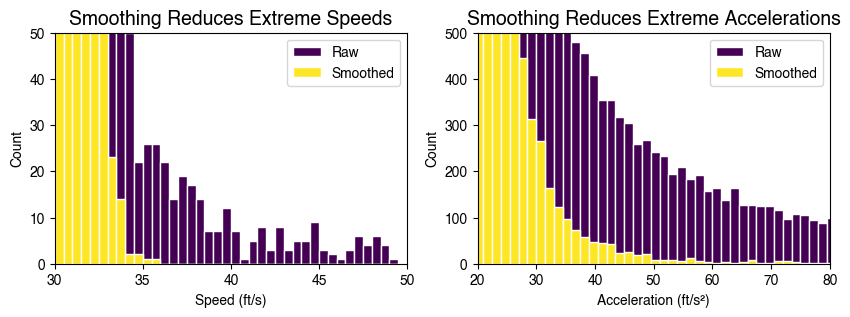

,batter,spd_max,spd_sm_max,spd_sm_statcast_max,acc_max,acc_sm_max,acc_sm_95th
771,YJD-0024,87.404826,27.222142,26.659896,2630.320349,45.225840,12.488708
810,YJD-0374,69.425029,34.770817,29.242859,1364.345977,223.145257,15.226831
274,JFU-1832,66.545819,30.455911,29.329343,793.967778,32.307397,22.369301
437,OWH-1707,65.790629,27.295037,26.361163,1308.345535,65.208586,9.470363
775,YJD-0067,62.506825,29.298885,27.738041,797.277038,44.676110,13.297084


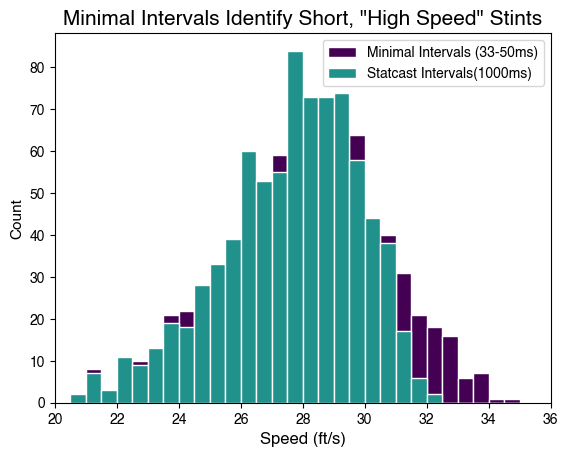

In [223]:
## 5. Compare & analyze
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]

# Speed subplot (left)
bins = np.arange(0,50,0.5)
axs[0].hist(runpos_sm['spd_to_1st'], bins=bins, edgecolor='white', alpha=1, label='Raw', color=colors[0])
axs[0].hist(runpos_sm['spd_to_1st_sm'], bins=bins, edgecolor='white', alpha=1, label='Smoothed', color=colors[2])
axs[0].set(xlim=(30, 50), ylim=(0, 50), xlabel='spd_to_1st', ylabel='Count')
axs[0].set_title('Smoothing Reduces Extreme Speeds', fontsize=14)
axs[0].set_xlabel('Speed (ft/s)')
axs[0].set_xticks(np.arange(30,51,5))
axs[0].legend()

# Acceleration subplot (right)
bins = np.arange(0,100,1.5)
axs[1].hist(runpos_sm['acc_to_1st'], bins=bins, edgecolor='white', alpha=1, label='Raw', color=colors[0])
axs[1].hist(runpos_sm['acc_to_1st_sm'], bins=bins, edgecolor='white', alpha=1, label='Smoothed', color=colors[2])
axs[1].set(xlim=(20, 80), ylim=(0, 500), xlabel='spd_to_1st', ylabel='Count')
axs[1].set_title('Smoothing Reduces Extreme Accelerations', fontsize=14)
axs[1].set_xlabel('Acceleration (ft/s²)')
axs[1].legend()
plt.show()

# Minimal Intervals Identify Short, "High Speed" Stints
leaderboard = runpos_sm.groupby(['batter']).agg(
    spd_max = ('spd_to_1st','max'), spd_sm_max = ('spd_to_1st_sm','max'),
    spd_sm_statcast_max = ('spd_to_1st_sm_statcast','max'),
    # spd_sm_95th = ('spd_to_1st_sm', lambda x: x.quantile(0.95)),
    acc_max = ('acc_to_1st','max'), acc_sm_max = ('acc_to_1st_sm','max'),
    acc_sm_95th = ('acc_to_1st_sm', lambda x: x.quantile(0.95))
).reset_index().sort_values('spd_max',ascending=False)
# numruns = runpos_sm.drop_duplicates(subset=['game_str','play_id']).groupby('batter').agg(count=('batter','size'))
# leaderboard = leaderboard.merge(numruns,how='left',on=['batter'])
bins = np.arange(20,36,0.5)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
plt.hist(leaderboard['spd_sm_max'],bins=bins, edgecolor='white', alpha=1, label='Minimal Intervals (33-50ms)', color=colors[0])
plt.hist(leaderboard['spd_sm_statcast_max'],bins=bins, edgecolor='white', alpha=1, label='Statcast Intervals(1000ms)', color=colors[1])
plt.xlim(20,36)
plt.title('Minimal Intervals Identify Short, "High Speed" Stints', fontsize=15)
plt.xlabel('Speed (ft/s)', fontsize=12)
plt.ylabel('Count', fontsize=11)
plt.legend()
leaderboard.head(5)


Text(0.2, 0.91, '(game_str = "y1_d048_STK_QEA", play_id = 217)')

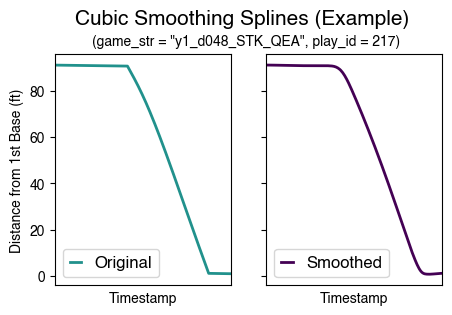

<Figure size 400x400 with 0 Axes>

In [ ]:
## Maybe animate this 1 point at a time and start at different timing
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
plt.figure(figsize=(4,4))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
mask = (runpos_sm['game_str'] == "y1_d048_STK_QEA") & (runpos_sm['play_id'] == 217)
subset = runpos_sm.loc[mask]
for i in range(2):
    axs[i].set_xlabel('Timestamp')
    axs[i].set_xticks([])
    axs[i].set_xticklabels("")
    axs[i].set_ylabel('Distance from 1st Base (ft)')
    axs[i].set_xlim(7.643000*1000000,7.652000*1000000)
axs[0].plot(subset['timestamp'], subset['ft_til_1st'], color=colors[1], lw=2, label='Original')
axs[0].legend(handlelength=0.7, loc='lower left', fontsize=12)
axs[1].plot(subset['timestamp'], subset['ft_til_1st_sm'], color=colors[0], lw=2, label='Smoothed')
axs[1].legend(handlelength=0.7, loc='lower left', fontsize=12)
fig.suptitle('Cubic Smoothing Splines (Example)', y=1.03, fontsize=15)
fig.text(x=0.2,y=0.91,s='(game_str = "y1_d048_STK_QEA", play_id = 217)')

In [11]:
"""
Export
"""
export = runpos_sm[['game_str','play_id','batter','contact_ts','timestamp',
                    'ft_til_1st_sm','spd_to_1st_sm','acc_to_1st_sm']]
export.to_csv('../CSV/running_smooth.csv', index=False)

In [12]:
"""
Filter by time_start_running
    1. Determine when batter starts running
    2. Get median time_start_running for each player
    3. Create cutoffs for time_start running
        (min(individual median time to start running + 250ms,
             group median time to start running + 350ms))
    4. Filter out timestamps before time_start_running
        (Save for later)
"""
# 1. Determine when batter starts running
# Only deal with timestamps after contact
start_running = runpos_sm[runpos_sm['timestamp']>runpos_sm['contact_ts']].copy()
# 2 consecutive timestamps (~100ms) faster than 3.0 fps towards target
MOVING_FPS = 3.0
start_running['moving'] = start_running['spd_to_1st'] >= MOVING_FPS
start_running['sustained_movement'] = (
    start_running.groupby(['game_str', 'play_id'])['moving']
    .transform(lambda x: x.rolling(window=2, min_periods=1).sum() >= 2))
start_running['sustained_movement'] = start_running.groupby(['game_str','play_id'])['sustained_movement'].shift(-3)
# Get the first timestamp as time_start_running
sustained_movement = start_running[start_running['sustained_movement']==True]
first_ts = sustained_movement.groupby(['game_str', 'play_id'])['timestamp'].transform('first')
start_running['startrun_ts'] = first_ts
start_running['time_to_run'] = start_running['startrun_ts'] - start_running['contact_ts']
start_running = start_running.groupby(['game_str','play_id']).agg(startrun_ts=('startrun_ts','max'),
                                                                  time_to_run=('time_to_run','max')).reset_index()
# # Another version
# start_running = runpos_sm[runpos_sm['timestamp']>runpos_sm['contact_ts']]
# TRAVEL = 5.0
# init_ft_til_1st = start_running.groupby(['game_str','play_id']).agg(init_ft_til_1st = ('ft_til_1st','first')).reset_index()
# start_running = start_running.merge(init_ft_til_1st,how='left',on=['game_str','play_id'])
# start_running = start_running[start_running['ft_til_1st'] < start_running['init_ft_til_1st'] - 5]
# start_running = start_running.groupby(['game_str','play_id']).agg(startrun_ts = ('timestamp','first'),
#                                                                             contact_ts = ('contact_ts','first')).reset_index()
# start_running['time_to_run'] = start_running['startrun_ts'] - start_running['contact_ts']
# start_running = start_running.drop(columns='contact_ts')

# Merge
runpos_sr = runpos_sm.merge(start_running,how="left",on=['game_str','play_id'])
print("\n Median time_to_run: ", runpos_sr['time_to_run'].median())

## 2. Get median time_start_running for each player
# time_start_running for each play
tsr_play = runpos_sr.groupby(['game_str','play_id','batter']).agg(time_to_run=('time_to_run','first'))
tsr_player = tsr_play.groupby(['batter']).agg(med_ttr = ('time_to_run','median'))
# Merge
runpos_sr = runpos_sr.merge(tsr_player,how="left",on='batter')

## 3. Create cutoffs for time_start running
runpos_sr['ttr_cutoff'] = np.minimum(runpos_sr['med_ttr'],runpos_sr['time_to_run'].median())
runpos_sr['time_lost'] = np.maximum(runpos_sr['time_to_run']-runpos_sr['ttr_cutoff'], 0)

## 4. Filter out timestamps before time_start_running
# Organize
runpos_sr = runpos_sr[['game_str','play_id','batter','hand','contact_ts','startrun_ts','time_to_run','ttr_cutoff','time_lost','timestamp','ft_til_1st_sm','spd_to_1st_sm','acc_to_1st_sm']]
# (Save for later)
timestamps_before_time_start_running = runpos_sr[runpos_sr['timestamp']<runpos_sr['startrun_ts']]
runpos_sr = runpos_sr[runpos_sr['timestamp']>=runpos_sr['startrun_ts']]

runpos_sr.head(4)


 Median time_to_run:  450.0


,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm
74,y1_d001_CGA_QEA,21,CGA-1824,R,560499,560749.0,250.0,250.0,0.0,560749,91.276741,5.896027,18.429326
75,y1_d001_CGA_QEA,21,CGA-1824,R,560499,560749.0,250.0,250.0,0.0,560799,90.981940,6.817493,19.642164
76,y1_d001_CGA_QEA,21,CGA-1824,R,560499,560749.0,250.0,250.0,0.0,560849,90.641065,7.799601,20.531749
77,y1_d001_CGA_QEA,21,CGA-1824,R,560499,560749.0,250.0,250.0,0.0,560899,90.251085,8.826189,20.128316


spds_p.head(5) 
      batter  plyr_spd_sm_max  run_ct
0  ACN-1147        27.874849       1
1  ACN-1180        28.946607       3
2  ACN-1276        27.264883       4
3  ACN-1338        24.196359       1
4  ACN-1416        28.805836       5


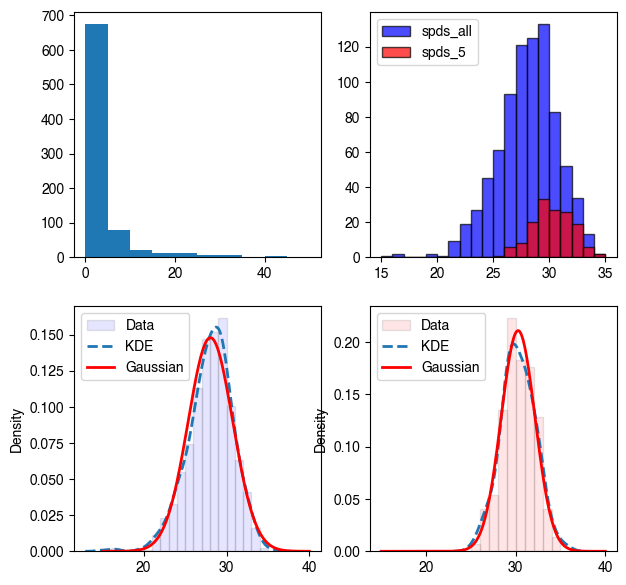

mu_1:  28.051382500098406
var_1:  7.2722326612048045
mu_5:  30.272641820065296
var_5:  3.5792990092571415
Method-of-moments λ_hat = 0.2392


In [13]:
"""
Reliably estimate maximum speed
    ((Soft) MAP estimation)

    1. Prepare data
    2. Exploratory data analysis
    3. (Soft) MAP estimation
    4. Merge

    (We use the distribution of maximum run speeds for
     runners with minimum 5 spds as the prior)
    (Runners with more spds overwhelm the prior)
    (See notes for proof)

    (Except when the prior is below recorded max speed)
"""
## 1. Prepare data
# Get max speeds of each run, then each player (with count)
spds = runpos_sr.groupby(['game_str','play_id','batter']).agg(spd_sm_max = ('spd_to_1st_sm','max'))
spds_p = spds.groupby('batter').agg(plyr_spd_sm_max = ('spd_sm_max','max'), 
                                    run_ct = ('spd_sm_max','size')).reset_index()
print("spds_p.head(5) \n", spds_p.head(5))

## 2. Exploratory data analysis
import seaborn as sns
from scipy.stats import norm
fig, axs = plt.subplots(2, 2, figsize=(7,7))
# We can see that the overwhelming majority of players 
# have [0,5) spds
bins = np.arange(0, 50 + 1, 5)
axs[0,0].hist(spds_p['run_ct'],bins=bins)
# We can see that the players with more spds 
# tend to have higher recorded maximum speeds
spd_bins = np.arange(15,35+1,1)
spds_all = spds_p[['plyr_spd_sm_max']].values
spds_5 = spds_p[spds_p['run_ct']>=5][['plyr_spd_sm_max']].values
axs[0,1].hist(spds_all,color='blue',bins=spd_bins,alpha=0.7,edgecolor='black',label='spds_all')
axs[0,1].hist(spds_5,color='red',bins=spd_bins,alpha=0.7,edgecolor='black',label='spds_5')
axs[0,1].legend()
# We can see that both distributions can be Gaussian approximated
mu_1, sd_1, var_1 = spds_all.mean(), spds_all.std(), spds_all.var()
axs[1,0].hist(spds_all,color='blue',bins=spd_bins,density=True,alpha=0.1,edgecolor='black',label='Data')
sns.kdeplot(spds_all,ax=axs[1,0],color='blue',linestyle='--',lw=2,label='KDE')
x_1 = np.linspace(15, 40, 500)
y_1 = norm.pdf(x_1, loc=mu_1, scale=sd_1)
axs[1,0].plot(x_1,y_1,'r-',lw=2,label='Gaussian')
axs[1,0].legend()
mu_5, sd_5, var_5 = spds_5.mean(), spds_5.std(), spds_5.var()
axs[1,1].hist(spds_5,color='red',bins=spd_bins,density=True,alpha=0.1,edgecolor='black',label='Data')
sns.kdeplot(spds_5,ax=axs[1,1],color='blue',linestyle='--',lw=2,label='KDE')
x_5 = np.linspace(15, 40, 500)
y_5 = norm.pdf(x_5, loc=mu_5, scale=sd_5)
axs[1,1].plot(x_5,y_5,'r-',lw=2,label='Gaussian')
axs[1,1].legend()
plt.show()
# We can see that the distribution with cutoff == 5 not only
# has a higher mean (as mentioned above), but also has less variance
print("mu_1: ", mu_1)
print("var_1: ", var_1)
print("mu_5: ", mu_5)
print("var_5: ", var_5)

## 3. (Soft) MAP estimation
y = spds_p[['plyr_spd_sm_max']].values   # observed best times
n = spds_p[['run_ct']].values            # num. qualifying spds
mu_prior = mu_5                          # prior mean
var_prior = var_5                        # prior variance
N = len(y)
# Method‐of‐moments for λ
lam_hat = 1/(mu_prior-np.mean(y)) * (1/N) * np.sum(1/n)
print(f"Method-of-moments λ_hat = {lam_hat:.4f}")
# Closed‐form MAP for each θ_i
theta_hat = mu_prior - lam_hat * n * var_prior
# Soften the estimation using y_i
ALPHA = 0.4
soft_est = ALPHA*y + (1-ALPHA)*theta_hat
mapsoft = np.maximum(y, soft_est)

## 4. Merge
spds_p['spd_sm_mapsoft_theta'] = pd.Series(mapsoft.flatten())

Text(0.5, 1.0, '(Softened) MAP Estimations')

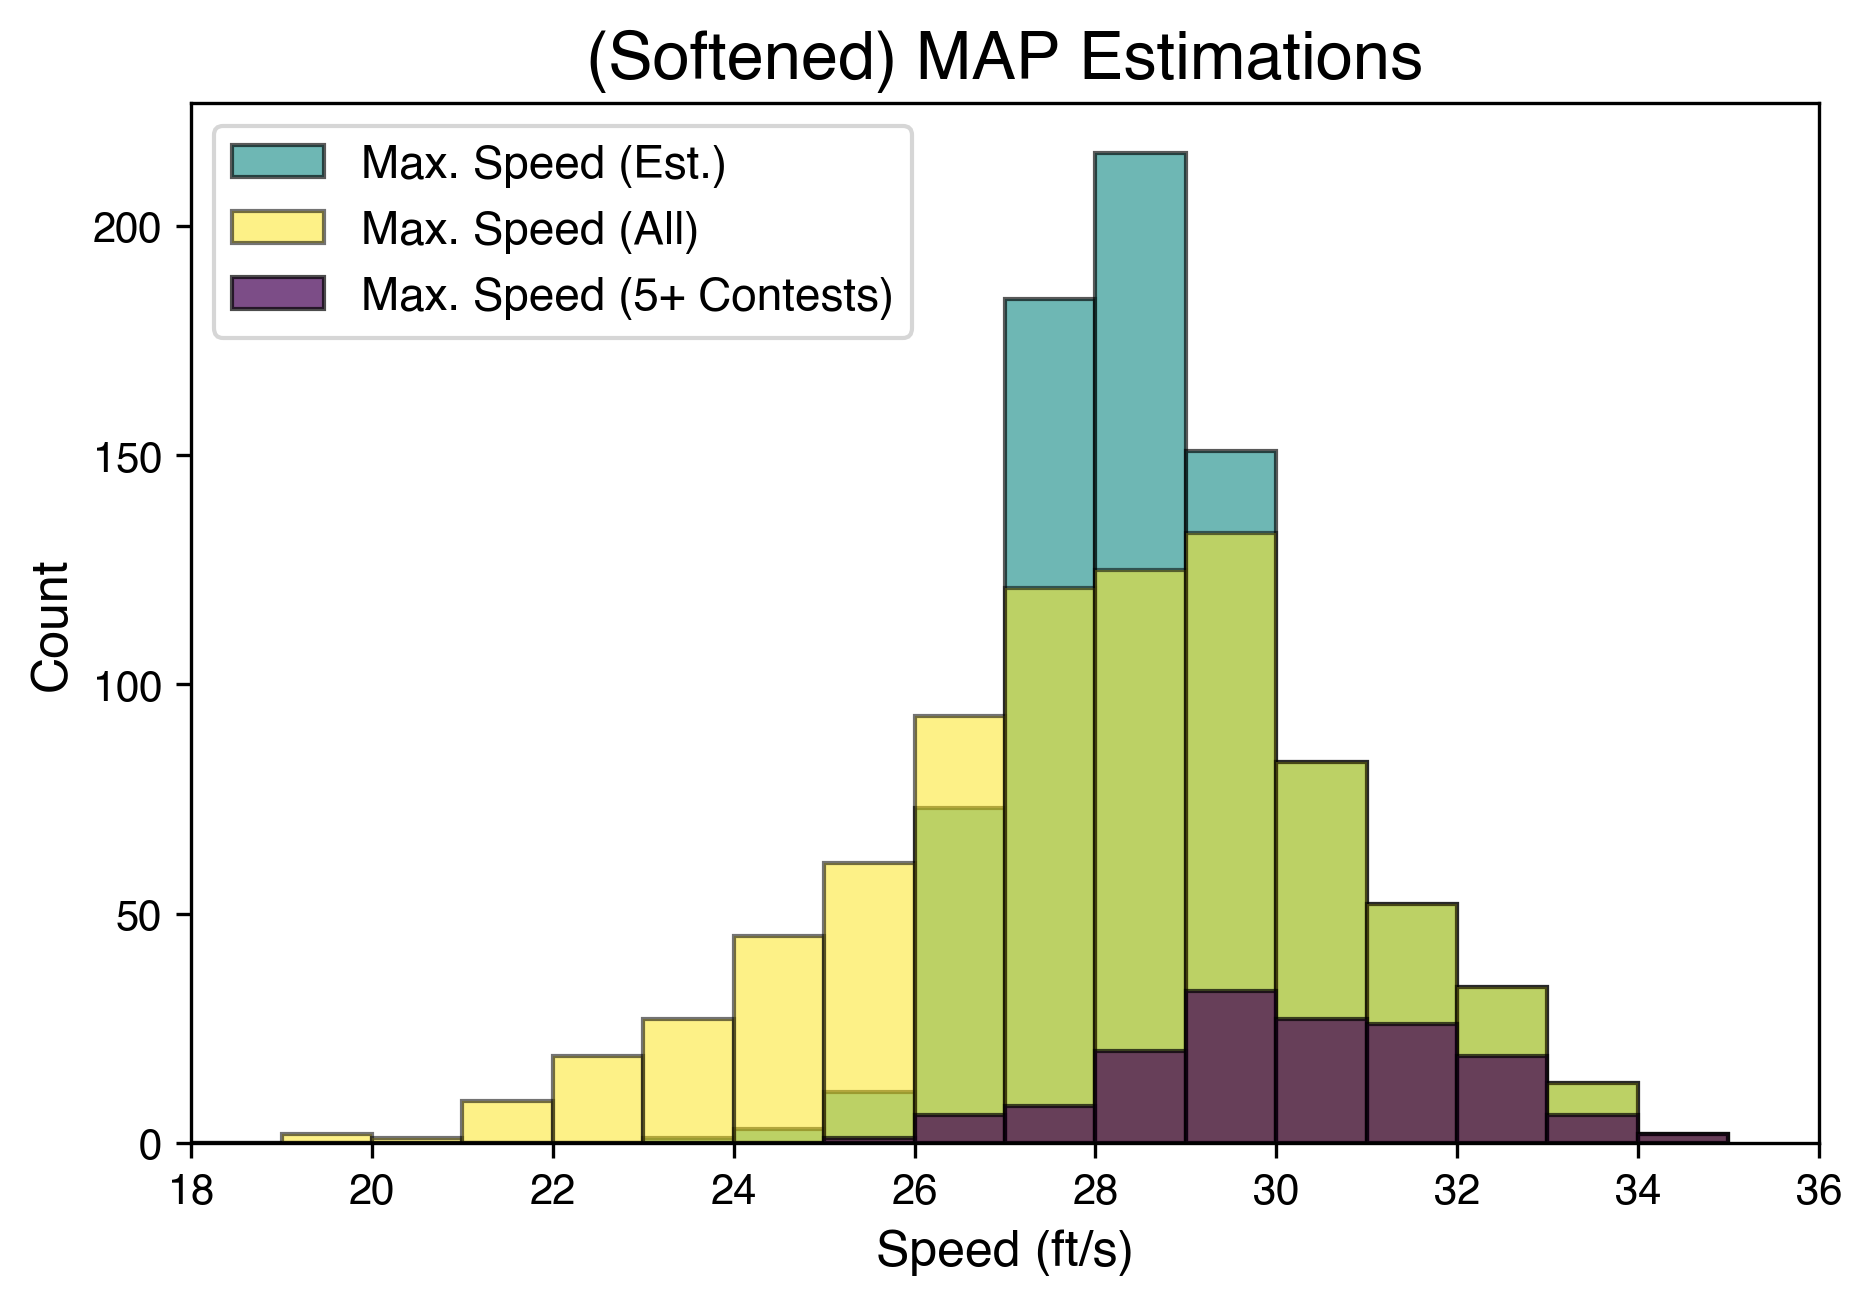

In [14]:
# Extra visualization
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
plt.figure(figsize=(7,4.5), dpi=300)
plt.hist(mapsoft,color=colors[1],bins=spd_bins,alpha=0.65,edgecolor='black',label='Max. Speed (Est.)')
plt.hist(spds_all,color=colors[2],bins=spd_bins,alpha=0.55,edgecolor='black',label='Max. Speed (All)')
plt.hist(spds_5,color=colors[0],bins=spd_bins,alpha=0.7,edgecolor='black',label='Max. Speed (5+ Contests)')
plt.legend(fontsize=11)
plt.xlim(18,36)
plt.xlabel('Speed (ft/s)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("(Softened) MAP Estimations", fontsize=16)

accs_p.head(5) 
      batter  int_5to10_ct  acc_5to10_95th  int_25to30_ct  acc_25to30_95th
0  ACN-1147             9       25.186314           42.0         4.371056
1  ACN-1180            43       15.467267           91.0         4.773257
2  ACN-1276            52       18.534115          117.0         2.756869
3  ACN-1338            16       14.278679            NaN              NaN
4  ACN-1416            64       23.370919          119.0         3.467078


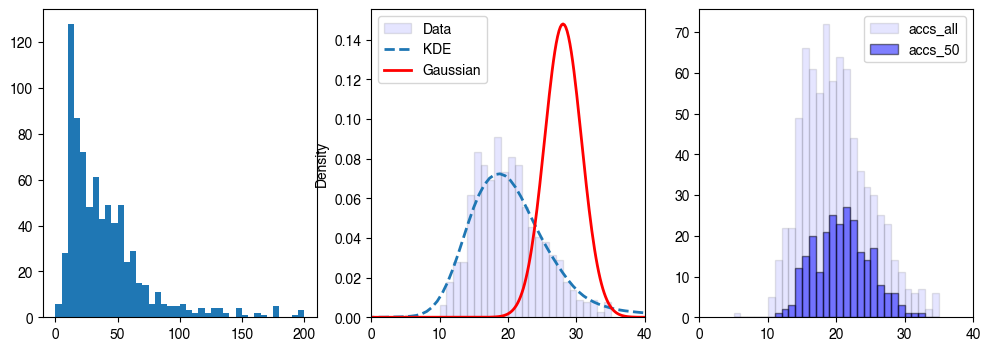

The distributions of 95th percentile speed with more intervals have less variance
(While keeping shape)
mu_all:  21.208168808732477
mu_50:  21.194359778573236
var_all:  75.09908671324092
var_50:  24.466354579755592
len(accs_all):  824
len(accs_50):  261


,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm
74,y1_d001_CGA_QEA,21,CGA-1824,R,560499,560749.0,250.0,250.0,0.0,560749,91.276741,5.896027,18.429326


In [33]:
"""
Reliably estimate 95th percentile acceleration
    (Variance reduction using z-scores)
    (Use 95th percentile for more reliability)
    1. Prepare data
    2. Exploratory data analysis
    3. Variance reduction using z-scores

    (Use 5 ft/s to 10 ft/s interval to gauge the 
     runner's "initial acceleration" capacity)

    (We also record acc_25to30_95th but this 
     is for the sake of comparison later)

"""
## 1. Prepare data
# Get interval counts for each batter
accs_5to10 = runpos_sr[(runpos_sr['spd_to_1st_sm']>5)&(runpos_sr['spd_to_1st_sm']<15)]
accs_5to10 = accs_5to10.groupby(['batter']).agg(int_5to10_ct = ('acc_to_1st_sm','size'),
                                                acc_5to10_95th = ('acc_to_1st_sm',lambda x: x.quantile(0.95))
                                                ).reset_index()

accs_25to30 = runpos_sr[(runpos_sr['spd_to_1st_sm']>25)&(runpos_sr['spd_to_1st_sm']<35)]
accs_25to30 = accs_25to30.groupby(['batter']).agg(int_25to30_ct = ('acc_to_1st_sm','size'),
                                                  acc_25to30_95th = ('acc_to_1st_sm',lambda x: x.quantile(0.95))
                                                  ).reset_index()
accs_p = pd.merge(accs_5to10,accs_25to30,how='outer',on='batter')
print("accs_p.head(5) \n", accs_p.head(5))

## 2. Exploratory data analysis
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# We can see that the majority of players have [0,100) accs
# Similar to how majority had [0,1) spds (see above)
bins = np.arange(0, 200 + 1, 5)
axs[0].hist(accs_p['int_5to10_ct'],bins=bins)
# We can see that the distribution of accs is also Gaussian
# With right skew
acc_bins = np.arange(5,35+1,1)
accs_all = accs_p[['acc_5to10_95th']].values
mu_all, sd_all, var_all = accs_all.mean(), accs_all.std(), accs_all.var()
axs[1].hist(accs_all,color='blue',bins=acc_bins,density=True,alpha=0.1,edgecolor='black',label='Data')
sns.kdeplot(accs_all,ax=axs[1],color='blue',linestyle='--',lw=2,label='KDE')
x_1 = np.linspace(0, 100, 500)
y_1 = norm.pdf(x_1, loc=mu_1, scale=sd_1)
axs[1].plot(x_1,y_1,'r-',lw=2,label='Gaussian')
axs[1].set_xlim(0,40)
axs[1].legend()
# Unlike spds,
# We can see that the players with more accs tend to have
# only slightly higher recorded 95th percentile accelerations
# But, they have significantly less variance
accs_50 = accs_p[accs_p['int_5to10_ct']>=50][['acc_5to10_95th']].values
axs[2].hist(accs_all,color='blue',bins=acc_bins,alpha=0.1,edgecolor='black',label='accs_all')
axs[2].hist(accs_50,color='blue',bins=acc_bins,alpha=0.5,edgecolor='black',label='accs_50')
axs[2].set_xlim(0,40)
axs[2].legend()
plt.show()
print("The distributions of 95th percentile speed with more intervals have less variance")
print("(While keeping shape)")
mu_50, var_50 = accs_50.mean(), accs_50.var()
print("mu_all: ", mu_all)
print("mu_50: ", mu_50)
print("var_all: ", var_all)
print("var_50: ", var_50)
print("len(accs_all): ", len(accs_all))
print("len(accs_50): ", len(accs_50))

## 3. Variance reduction using z-scores
accs_p['z-score'] = (accs_p['acc_5to10_95th'] - mu_1) / np.sqrt(var_1)
accs_p['acc_5to10_95th_scaled'] = accs_p['z-score']*np.sqrt(var_50) + mu_50

runpos_sr.head(1)

Text(0.5, 1.0, 'Distribution of 95th Percentile Acceleration')

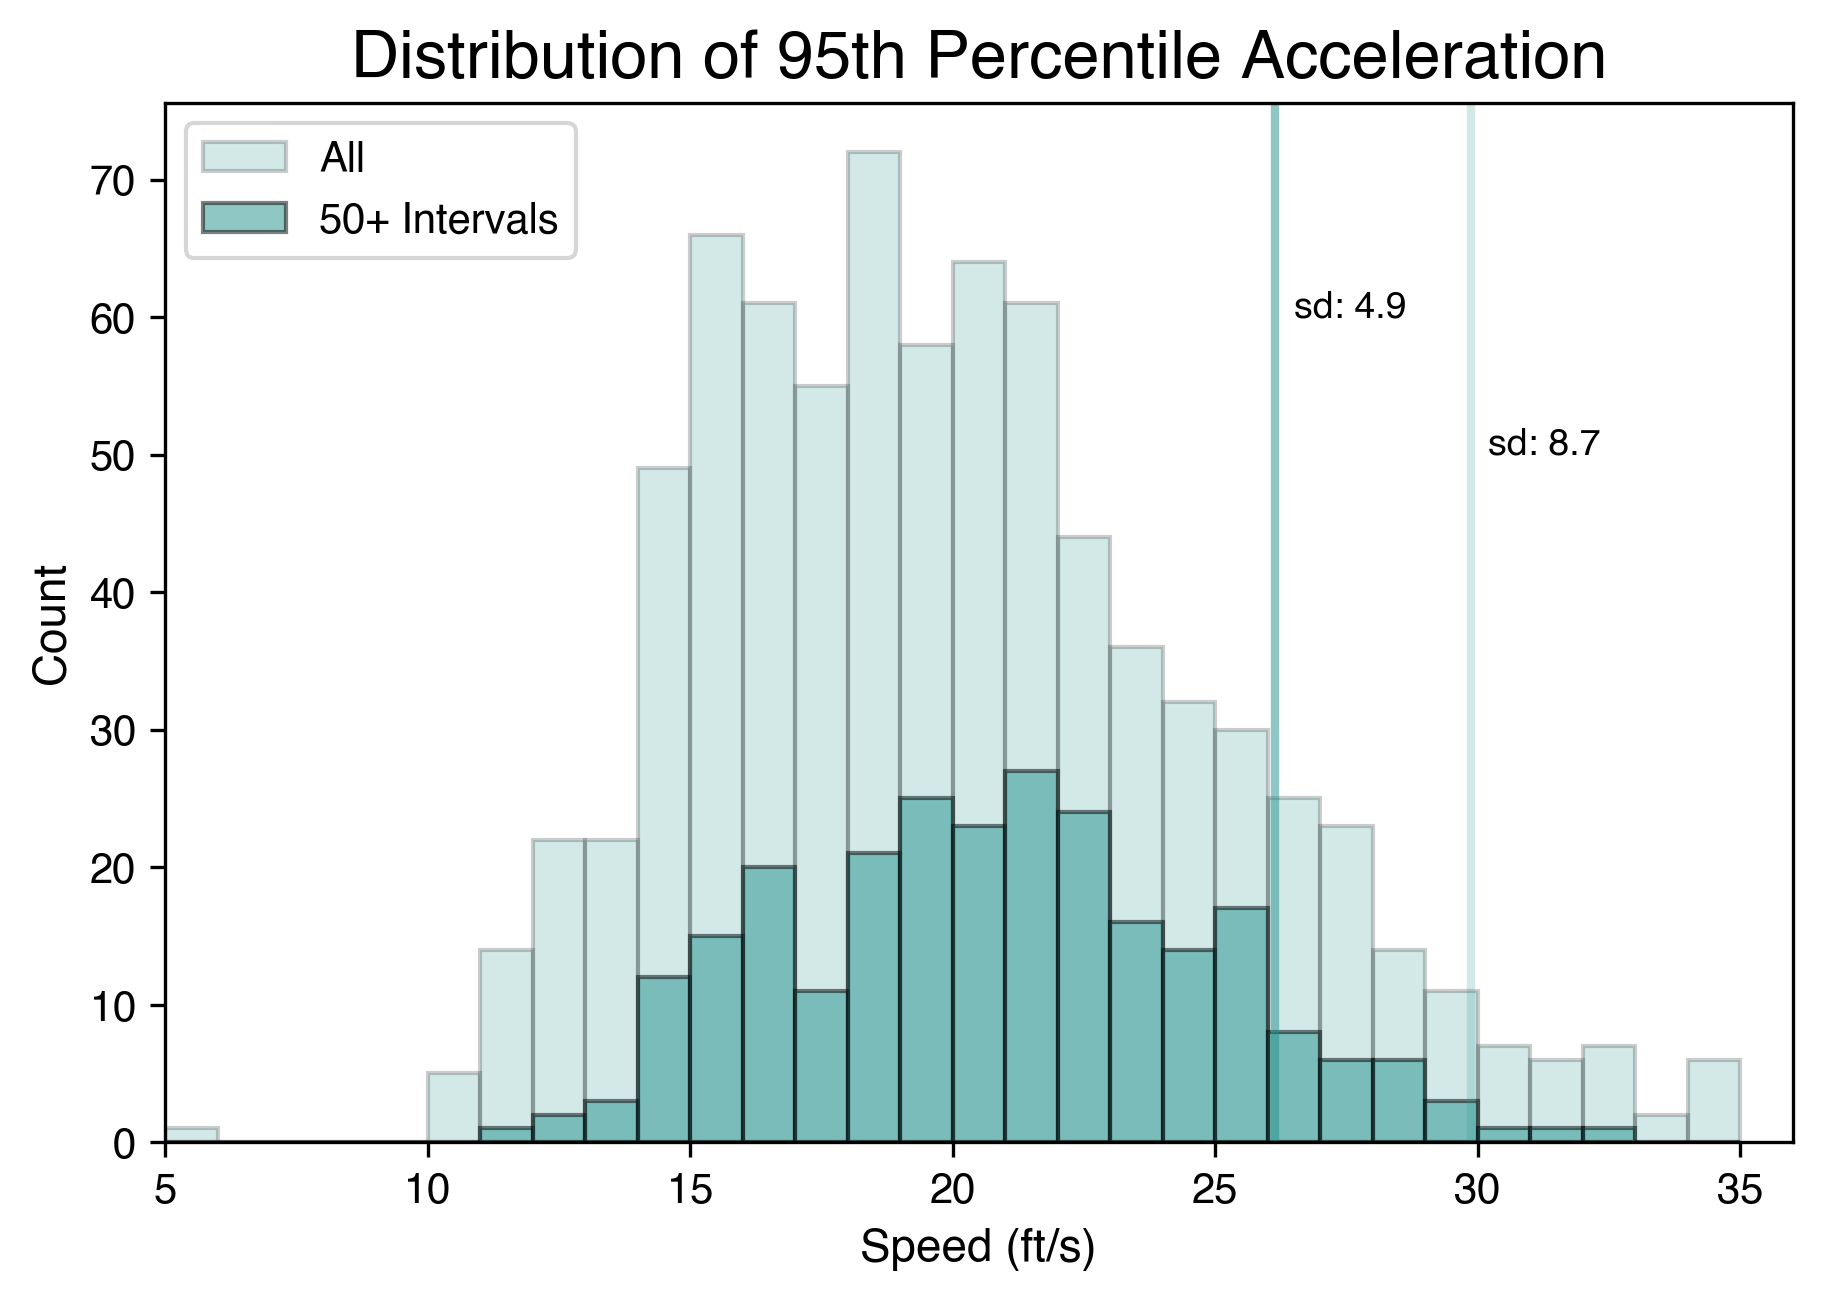

In [34]:
# Visualization
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
plt.figure(figsize=(7,4.5), dpi=300)
plt.hist(accs_all,color=colors[1],bins=acc_bins,alpha=0.2,edgecolor='black',label='All')
plt.hist(accs_50,color=colors[1],bins=acc_bins,alpha=0.5,edgecolor='black',label='50+ Intervals')
plt.axvline(x=mu_all+np.sqrt(var_all), color=colors[1], ls='-', alpha=0.2, lw=2)
plt.axvline(x=mu_50+np.sqrt(var_50), color=colors[1], ls='-', alpha=0.5, lw=2)
plt.text(x=26.5,y=60, s=f'sd: {round(np.sqrt(var_50),1)}', fontsize=9)
plt.text(x=30.2,y=50, s=f'sd: {round(np.sqrt(var_all),1)}', fontsize=9)
plt.legend()
plt.xlim(5,36)
plt.xlabel('Speed (ft/s)', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title("Distribution of 95th Percentile Acceleration", fontsize=16)

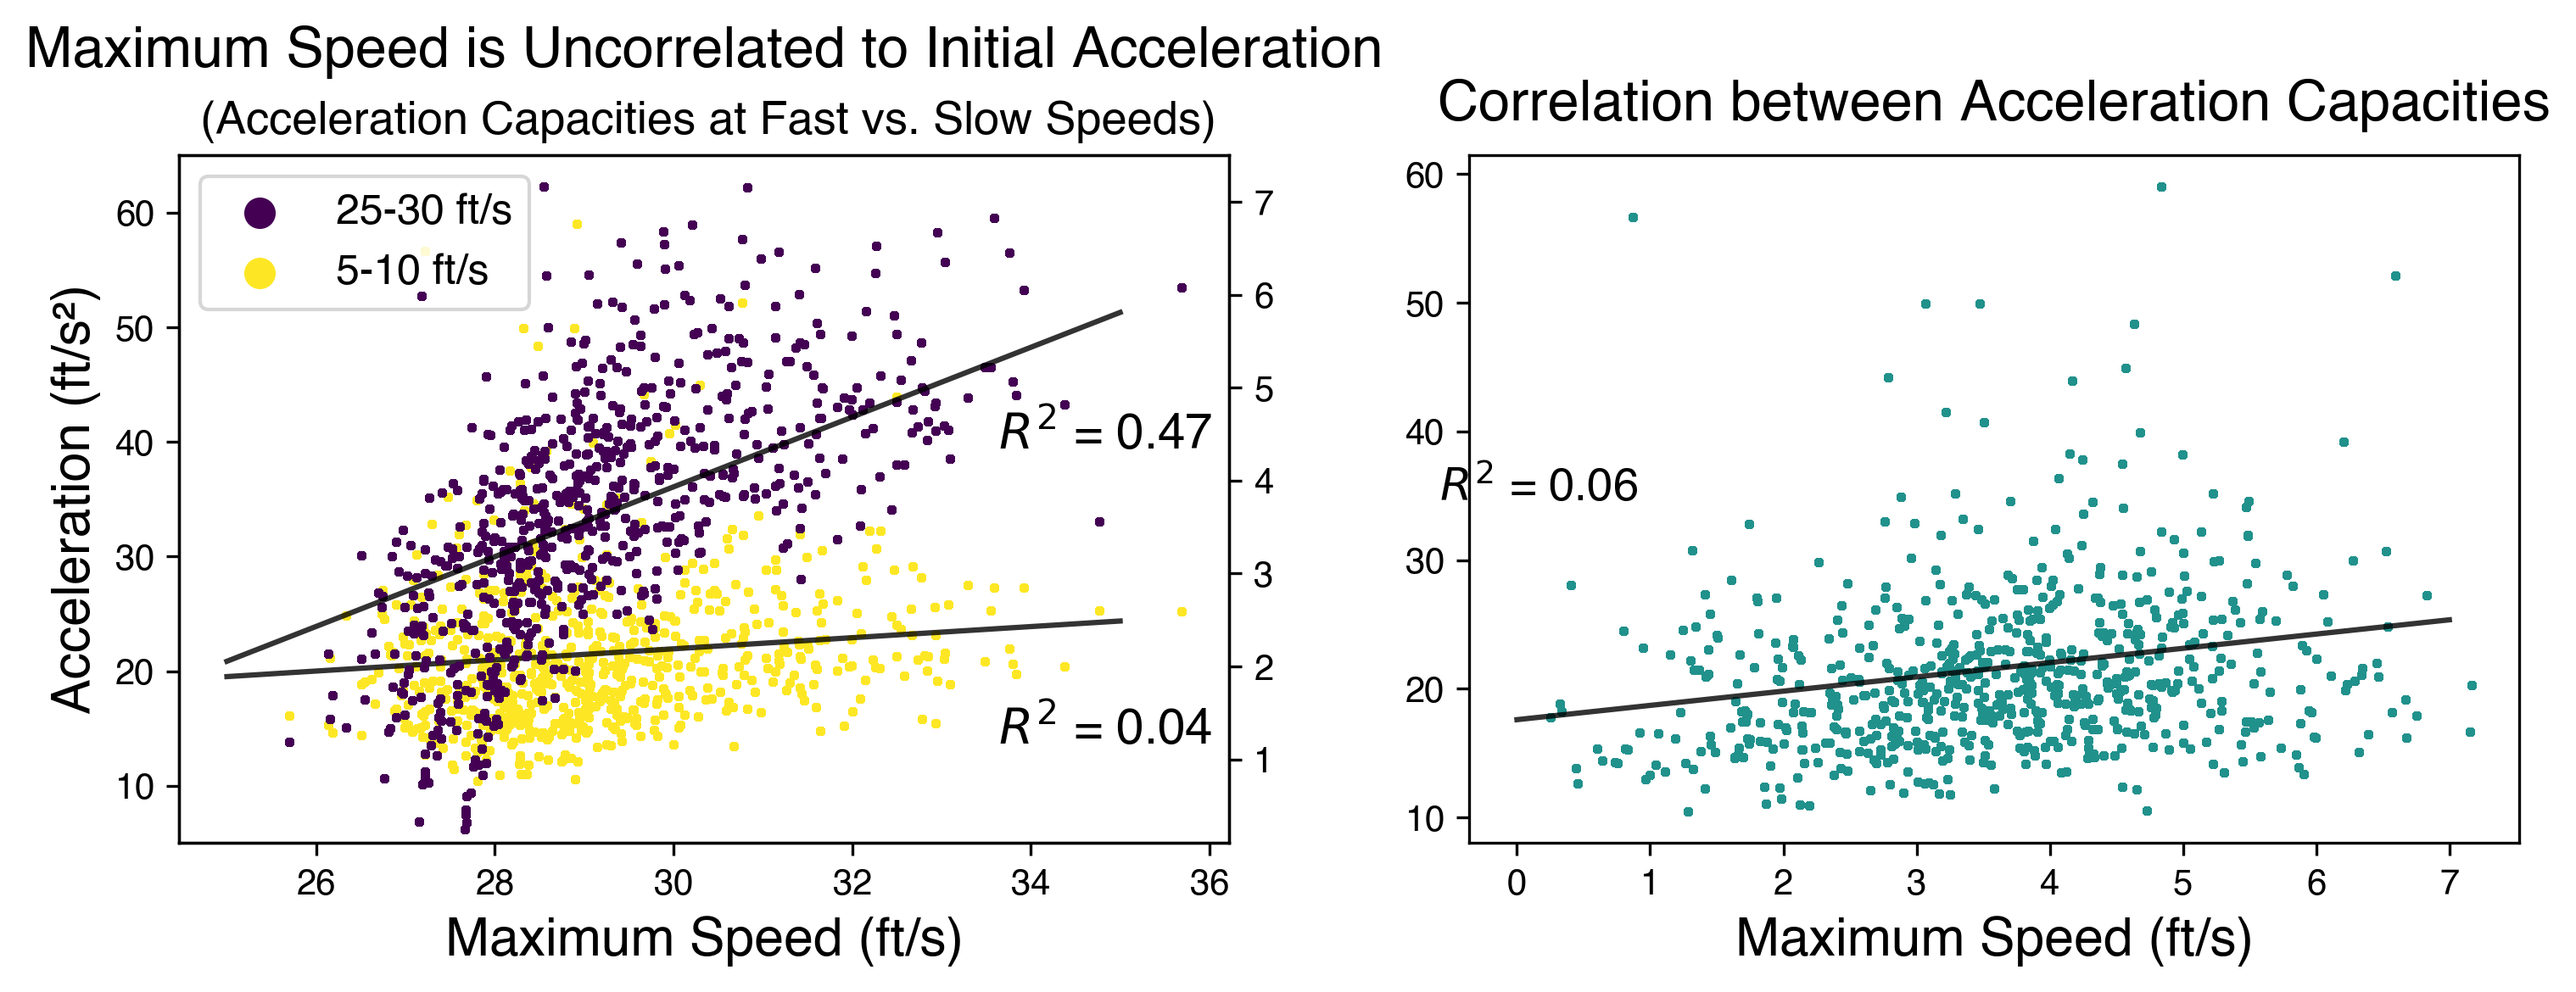

In [35]:
"""
Combine & Analyze
    1. Combine
    2. Analyze
"""
## 1. Combine
runpos_final = pd.merge(runpos_sr, spds_p[['batter','spd_sm_mapsoft_theta']],how="left",on='batter')
runpos_final = pd.merge(runpos_final, accs_p[['batter','acc_5to10_95th','acc_25to30_95th']],how="left",on='batter')
# Remove outliers
runpos_final.loc[runpos_final['acc_5to10_95th'] > 60] = np.nan
runpos_final.loc[runpos_final['acc_25to30_95th']> 8] = np.nan
# Remove NA's
runpos_final = runpos_final.dropna(subset=['batter','acc_to_1st_sm'])

## 2. Analyze
from scipy.stats import linregress
# We can see that acc_5to10_95th has little correlation to maximum speed
# But acc_25to30_95th as strong correlation to maximum speed
# Futhermore we can see that they're not correlated to each other
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
# Get data
temp = runpos_final.dropna(subset=['acc_5to10_95th','acc_25to30_95th','spd_sm_mapsoft_theta'])
data = [[temp['spd_sm_mapsoft_theta'],temp['acc_5to10_95th']],
        [temp['spd_sm_mapsoft_theta'],temp['acc_25to30_95th']],
        [temp['acc_25to30_95th'],temp['acc_5to10_95th']]]
r_list = []
# Left plot
ax2 = axs[0].twinx()
for i in range(2):
    slope, intercept, r, p, se = linregress(data[i][0], data[i][1])
    r_list.append(r)
    line_x = np.linspace(25,35,100)
    line_y = slope*line_x + intercept
    ax = axs[0] if i == 0 else ax2      
    ax.plot(line_x, line_y, color='black', lw=1.5, alpha=0.8)
axs[0].set_title('Maximum Speed is Uncorrelated to Initial Acceleration', fontsize=16, pad=25)
axs[0].text(0.02,1.08, '(Acceleration Capacities at Fast vs. Slow Speeds)',transform=ax.transAxes,fontsize=13,va='top')
sca_0 = axs[0].scatter(data[0][0], data[0][1], color=colors[2], s=2.5, label='5-10 ft/s')
sca_1 = ax2.scatter(data[1][0], data[1][1], color=colors[0], s=2.5, label='25-30 ft/s')
axs[0].text(0.78, 0.2, f'$R^2$ = {r_list[0]**2:.2f}',transform=ax.transAxes,fontsize=14,va='top')
axs[0].text(0.78, 0.63, f'$R^2$ = {r_list[1]**2:.2f}',transform=ax.transAxes,fontsize=14,va='top')
axs[0].set_xlabel('Maximum Speed (ft/s)', fontsize=15)
axs[0].set_ylabel('Acceleration (ft/s²)', fontsize=15)
axs[0].set_ylim(5,65)
ax2.set_ylim(0.1,7.5)
axs[0].legend(handles=[sca_1,sca_0], loc=2, markerscale=5, fontsize=12)
# Right plot
slope, intercept, r, p, se = linregress(data[2][0], data[2][1])
line_x = np.linspace(0,7,100)
line_y = slope*line_x + intercept
axs[1].plot(line_x, line_y, color='black', lw=1.5, alpha=0.8)
axs[1].set_title('Correlation between Acceleration Capacities', fontsize=16, pad=10)
axs[1].scatter(data[2][0], data[2][1], color=colors[1], s=2.5)
axs[1].text(1.2, 0.55, f'$R^2$ = {r**2:.2f}',transform=ax.transAxes,fontsize=13,va='top')
axs[1].set_xlabel('Maximum Speed (ft/s)', fontsize=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '(Diff. Top Speeds)')

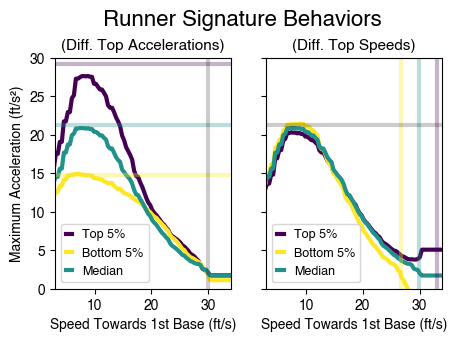

In [52]:
"""
Fit ML model for maximum acceleration at given speed & runner signature
    (At given speed & runner signature)
    1. Get X, y
    2. Split X, y into train/val/test
    3. Create prep data structures
    4. Train CatBoost
    5. Bagging
    5. Evaluate

    (We use 0.90 quantile acceleration because its peak matched
     well with given acceleration and lower quantile is more reliable)

    (For this ensembling process we omitted LGBM
     because it did not allow combination of 
     quantile regression + monotonic constraint)

    (Pinball loss)
    (Monotonic constraint)
"""
import catboost as cat  
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import train_test_split
import optuna
SEED = 42
QUANTILE = 0.90
sampler = optuna.samplers.TPESampler(seed=SEED)

## 1. Get X, y
# X = runpos_final[['spd_to_1st_sm','spd_sm_mapsoft_theta','acc_5to10_95th']]
# y = runpos_final['acc_to_1st_sm'].astype(np.float32)
# z = runpos_final['batter']

# ## 2. Split X, y into train/val/test
# # (z is just for Stratified K-fold; preserving class ratios)
# # (In our case the "class ratio" is batter ratios)
# X_trainval, X_test, y_trainval, y_test, z_trainval, z_test = train_test_split(
#     X, y, z, test_size=0.2, random_state=SEED, stratify=z)
# X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(
#     X_trainval, y_trainval, z_trainval, test_size=0.5, 
#     random_state=SEED, stratify=z_trainval)

# ## 3. Create prep data structures
# # Catboost Pool
# train_pool = cat.Pool(X_train, label=y_train)
# val_pool = cat.Pool(X_val, label=y_val)
# test_pool = cat.Pool(X_test, label=y_test)

# ## 4. Train CatBoost
# OPTUNA_NTRIALS_CAT = 1000
# print("Starting optuna CatBoost study...")
# cat_models = []
# def objective_cat(trial: optuna.Trial):
#     params = {  "task_type": "GPU",  # CatBoost doesn't support GPU for many things we're doing here
#                 # Use the quantile objective function.
#                 "loss_function": f"Quantile:alpha={QUANTILE}",
#                 "depth": trial.suggest_int("depth", 2, 5),
#                 "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
#                 # "subsample": 1,
#                 # "rsm": 1,
#                 "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
#                 "random_strength": trial.suggest_int("random_strength", 1, 20, log=True),
#                 "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 500, log=True),
#                 "iterations": 1000, 
#                 # Monotonic constraint with respect to speed (3rd feature)
#                 # "monotone_constraints": [-1,0,0],
#                 "verbose": False,
#                 "random_seed": SEED   }
#     model = cat.CatBoostRegressor(**params)
#     model.fit(
#         train_pool,
#         eval_set=val_pool,
#         early_stopping_rounds=10,
#         use_best_model=True,
#         verbose=False)
#     cat_models.append(model)
#     y_pred = model.predict(X_val)
#     return mean_pinball_loss(y_pred, y_val, alpha=QUANTILE)
# # CatBoost study
# cat_study = optuna.create_study(sampler=sampler)
# cat_study.optimize(objective_cat, n_trials=OPTUNA_NTRIALS_CAT)

# ## X. Feature importance
# # Feature importance
# fi = [model.get_feature_importance() for model in cat_models]
# mean_fi = np.mean(fi, axis=0)
# print("Mean feature importance: ", mean_fi)

# ## 5. Bagging
# # (Ensemble; Average the predictions)
# # (Use all 1000 models because it's for variance reduction)
# from Helpers import Ensemble
# TOP = 900
# # Save model
# for i in range(TOP):
#     cat_models[i].save_model(f'../Models/max_acc_cap_models/max_acc_cap_model_catboost_{i}')
# # Create ensemble
# cat_trials = [t for t in cat_study.trials if t.value is not None]
# top_cats = sorted(cat_trials, key=lambda t: t.value, reverse=True)[:TOP]
# top_ids_cats = [t.number for t in top_cats]
# cat_ensemble = Ensemble([cat_models[top_ids_cats[i]] for i in range(TOP)])



## For quickness
from Helpers import Ensemble
TOP_0 = 1000
cat_models = []
for i in range(TOP_0):
    model = cat.CatBoostRegressor()
    model.load_model(f'../Models/max_acc_cap_models/max_acc_cap_model_catboost_{i}')
    cat_models.append(model)
cat_ensemble = Ensemble([cat_models[i] for i in range(TOP_0)])



## 6. Evaluate
# Median & 5th & 95th percentile acceleration and max speed
spd_median = runpos_final['spd_sm_mapsoft_theta'].median()
spd_5th_perc = runpos_final['spd_sm_mapsoft_theta'].quantile(0.05)
spd_95th_perc = runpos_final['spd_sm_mapsoft_theta'].quantile(0.95)
acc_median = runpos_final['acc_5to10_95th'].median()
acc_5th_perc = runpos_final['acc_5to10_95th'].quantile(0.05)
acc_95th_perc = runpos_final['acc_5to10_95th'].quantile(0.95)
# Plot
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
maxspeeds = [[spd_median]*3, [spd_95th_perc, spd_5th_perc, spd_median]]
maxaccs =   [[acc_95th_perc, acc_5th_perc, acc_median], [acc_median]*3]
for i in range(2):
    samples = [pd.DataFrame({'spd_to_1st_sm': np.linspace(0,35,100),'spd_sm_mapsoft_theta': maxspeeds[i][j],'acc_5to10_95th': maxaccs[i][j]})
               for j in range(3)]
    imaginary_batters = samples.copy()
    for j in range(3):
        imaginary_batters[j]['max_acc_capacity_ensemble'] = cat_ensemble.predict(samples[j])
    axs[i].plot(imaginary_batters[0][imaginary_batters[0]['spd_sm_mapsoft_theta']==maxspeeds[i][0]]['spd_to_1st_sm'], 
                imaginary_batters[0]['max_acc_capacity_ensemble'], color=colors[0], lw=3, label='Top 5%')
    axs[i].plot(imaginary_batters[1][imaginary_batters[1]['spd_sm_mapsoft_theta']==maxspeeds[i][1]]['spd_to_1st_sm'], 
                imaginary_batters[1]['max_acc_capacity_ensemble'], color=colors[2], lw=3, label='Bottom 5%')
    axs[i].plot(imaginary_batters[2][imaginary_batters[2]['spd_sm_mapsoft_theta']==maxspeeds[i][2]]['spd_to_1st_sm'], 
                imaginary_batters[2]['max_acc_capacity_ensemble'], color=colors[1], lw=3, label='Median')
    axs[i].set_xlabel('Speed Towards 1st Base (ft/s)')
    axs[i].legend(fontsize=9, loc='lower left', handlelength=0.5)
    if i == 0:
        axs[i].axhline(y=maxaccs[i][0], color=colors[0], lw=3, alpha=0.3)
        axs[i].axhline(y=maxaccs[i][1], color=colors[2], lw=3, alpha=0.35)
        axs[i].axhline(y=maxaccs[i][2], color=colors[1], lw=3, alpha=0.3)
        axs[i].axvline(x=spd_median, color='black', lw=3, alpha=0.2)
    else:
        axs[i].axvline(x=maxspeeds[i][0], color=colors[0], lw=3, alpha=0.3)
        axs[i].axvline(x=maxspeeds[i][1], color=colors[2], lw=3, alpha=0.35)
        axs[i].axvline(x=maxspeeds[i][2], color=colors[1], lw=3, alpha=0.3)
        axs[i].axhline(y=acc_median, color='black', lw=3, alpha=0.2)
    axs[i].set_xlim(3,34)
    axs[i].set_xticks(np.arange(10,31,10))
    axs[i].set_ylim(0,30)
    axs[i].set_yticks(np.arange(0,31,5))
plt.suptitle('Runner Signature Behaviors', fontsize=16, y=1.04)
axs[0].set_ylabel('Maximum Acceleration (ft/s²)')
axs[0].set_title('(Diff. Top Accelerations)', fontsize=11)
axs[1].set_title('(Diff. Top Speeds)', fontsize=11)

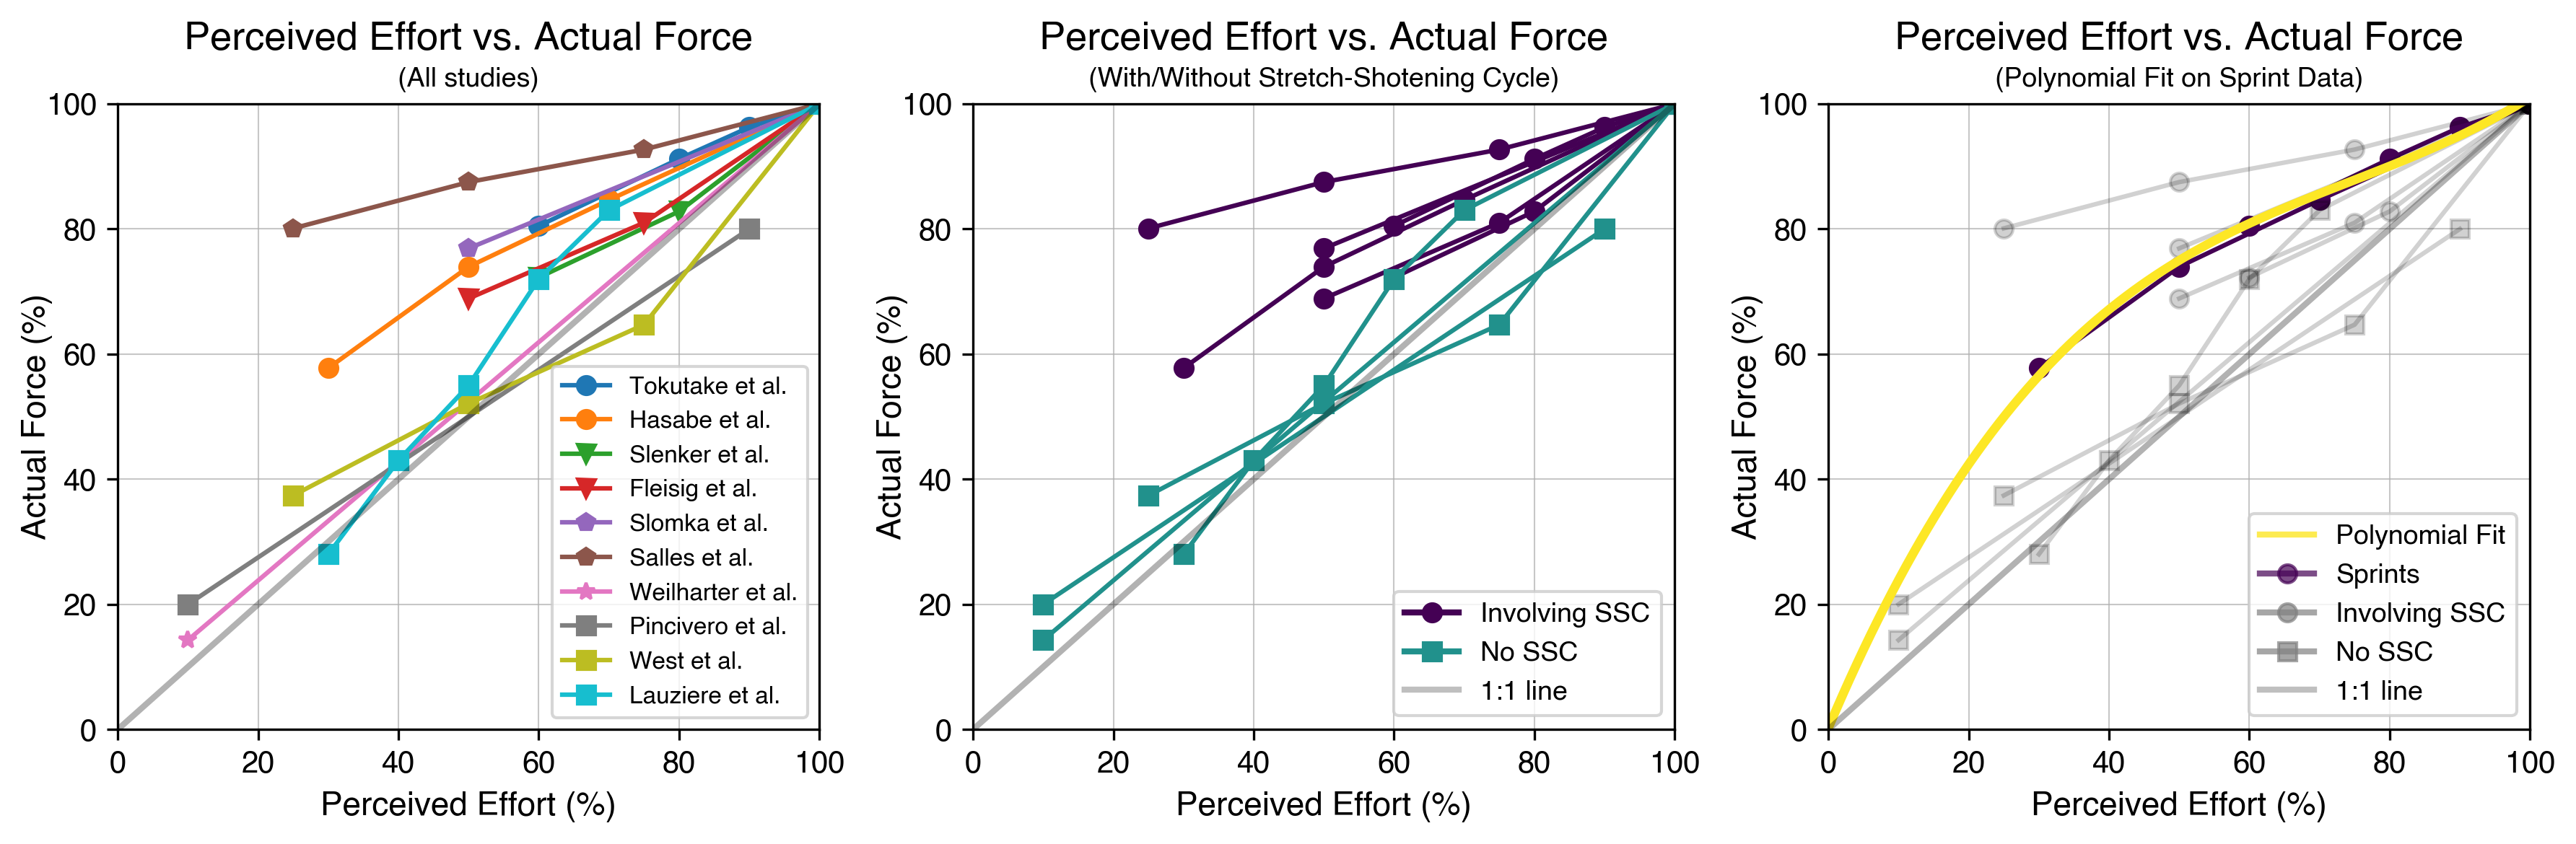

In [37]:
"""
Investigate acceleration at effort levels
    Using studies
    (Polynomial Fit)
    1. Prepare dataset
    2. Initial plot
    3. Group by SSC
    4. Fit polynomial to the 2 sprint datasets
"""
from matplotlib.lines import Line2D
import pickle

## 1. Prepare dataset 
# (Absolute/Perceived Relative Intensity)
label_tokutake = "Tokutake et al."
x_tokutake = [0.6,0.8,0.9,1]
y_tokutake_raw = [0.8972,0.955,0.9811,1]
y_tokutake = [y_tokutake_raw[i]**2 for i in range(4)]  # Force estimation
label_hasabe = "Hasabe et al."
x_hasabe = [0.3,0.5,0.7,1]
y_hasabe_raw = [0.76,0.86,0.92,1]
y_hasabe = [y_hasabe_raw[i]**2 for i in range(4)]  # Force estimation
label_slenker = "Slenker et al."
x_slenker = [0.6,0.8,1]
y_slenker_raw = [0.85,0.91,1]
y_slenker = [y_slenker_raw[i]**2 for i in range(3)]  # Force estimation
label_fleisig = "Fleisig et al."
x_fleisig = [0.5,0.75,1]
y_fleisig_raw = [0.83,0.9,1]
y_fleisig = [y_fleisig_raw[i]**2 for i in range(3)]  # Force estimation
label_slomka = "Slomka et al."
x_slomka = [0.5,1]
y_slomka = [0.769,1]
label_salles = "Salles et al."
x_salles = [0.25,0.5,0.75,1]
y_salles = [0.801,0.875,0.927,1]
label_weilharter = "Weilharter et al."
x_weilharter = [0.1,1]
y_weilharter = [0.1*(1/0.7),0.7*(1/0.7)]  # Scale 70% to 100%
label_pincivero = "Pincivero et al."
x_pincivero = [0.1,0.9]
y_pincivero = [0.2,0.8]
label_west = "West et al."
x_west = [0.25,0.5,0.75,1]
y_west = [0.374,0.521,0.647,1]
label_lauziere = "Lauziere et al."
x_lauziere = [0.3,0.4,0.5,0.6,0.7,1]
y_lauziere = [0.28,0.43,0.55,0.72,0.83,1]
# Dataset
dataset_x = [x_tokutake,x_hasabe,x_slenker,x_fleisig,x_slomka,x_salles,x_weilharter,x_pincivero,x_west,x_lauziere]
dataset_y = [y_tokutake,y_hasabe,y_slenker,y_fleisig,y_slomka,y_salles,y_weilharter,y_pincivero,y_west,y_lauziere]
labels = [label_tokutake,label_hasabe,label_slenker,label_fleisig,label_slomka,label_salles,label_weilharter,label_pincivero,label_west,label_lauziere]
activities_marker = ['o','o','v','v','p','p','*','s','s','s']

## 2. Initial plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
for i in range(10):
    axs[0].plot(dataset_x[i],dataset_y[i],marker=activities_marker[i],label=labels[i])
axs[0].legend(fontsize=8)
axs[0].text(0.5, 1.018,"(All studies)",
            transform=axs[0].transAxes, ha="center", va="bottom", fontsize=9)

## 3. Group by SSC
ssc_color = [colors[0],colors[0],colors[0],colors[0],colors[0],
             colors[0],colors[1],colors[1],colors[1],colors[1]]
ssc_marker = ['o','o','o','o','o','o','s','s','s','s']
for i in range(10):
    axs[1].plot(dataset_x[i],dataset_y[i],marker=ssc_marker[i],color=ssc_color[i])
axs[1].text(0.5, 1.018,"(With/Without Stretch-Shotening Cycle)",
            transform=axs[1].transAxes, ha="center", va="bottom", fontsize=9)
custom_legend_1 = [
    Line2D([0], [0], color=colors[0], marker='o', lw=2, label='Involving SSC'),
    Line2D([0], [0], color=colors[1], marker='s', lw=2, label='No SSC'),
    Line2D([0], [0], color='gray', lw=2, alpha=0.5, label='1:1 line')]
axs[1].legend(handles=custom_legend_1, fontsize=9)

## 4. Fit polynomial to the 2 sprint datasets
sprint_color = [colors[0],colors[0],"#0000002E",'#0000002E','#0000002E',
                "#0000002E","#0000002E",'#0000002E','#0000002E','#0000002E']
for i in range(10):
    axs[2].plot(dataset_x[i],dataset_y[i],marker=ssc_marker[i],color=sprint_color[i])
axs[2].text(0.5, 1.018,"(Polynomial Fit on Sprint Data)",
            transform=axs[2].transAxes, ha="center", va="bottom", fontsize=9)
x_hybrid = [0,0.3,0.5,0.6,0.7,0.8,0.9,1]
y_hybrid_raw = [0,0.76,0.86,0.8972,0.92,0.955,0.9811,1]
y_hybrid = [y_hybrid_raw[i]**2 for i in range(8)]
# Polynomial fit
coeffs = np.polyfit(x_hybrid,y_hybrid,deg=3)
# Export
with open('../Models/effort_model_coeffs.pkl', 'wb') as f:
    pickle.dump(coeffs, f)
x_fit = np.linspace(0,1,100)
y_fit = np.polyval(coeffs,x_fit)
axs[2].plot(x_fit,y_fit,color=colors[2],alpha=1, lw=3)
custom_legend_2 = [
    Line2D([0], [0], color=colors[2], alpha=0.8, lw=2,label='Polynomial Fit'),
    Line2D([0], [0], color=colors[0], alpha=0.7, marker='o', lw=2, label='Sprints'),
    Line2D([0], [0], color="grey", alpha=0.7, marker='o', lw=2, label='Involving SSC'),
    Line2D([0], [0], color='grey', alpha=0.7, marker='s', lw=2, label='No SSC'),
    Line2D([0], [0], color='grey', lw=2, alpha=0.5, label='1:1 line')]
axs[2].legend(handles=custom_legend_2, fontsize=9)

## X. Print
for i in range(3):
    axs[i].set_title('Perceived Effort vs. Actual Force', fontsize=13, pad=18)
    axs[i].set_xlabel('Perceived Effort (%)', fontsize=11)
    axs[i].set_ylabel('Actual Force (%)', fontsize=11, labelpad=-2)
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xticks(np.arange(0, 1.1, 0.2))
    axs[i].set_xticklabels(np.arange(0, 101, 20))  # Convert to percentages
    axs[i].set_yticks(np.arange(0, 1.1, 0.2))
    axs[i].set_yticklabels(np.arange(0, 101, 20))
    axs[i].plot([0,1],[0,1],'k',lw=2,alpha=0.3,label="1:1 line")
    axs[i].grid(True, lw=0.5, alpha=0.7)    
plt.tight_layout()
plt.show()

Mean effort level:                            75.56%
Median effort level:                          83.4%
Percentage of runs that included 100% effort: 78.59%


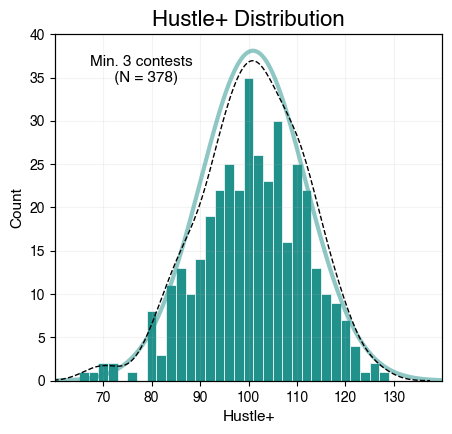

In [224]:
"""
Infer effort level (intent)
    Calculate Hustle+
    1. Estimate maximum acceleration capacity using ML model
    2. Get force %
    3. Calculate effort level
    4. Calculate Hustle+ for each play
    5. Evaluate
# """
# 1. Estimate maximum acceleration capacity using ML model
running = runpos_final.copy()
running["max_acc_cap"] = cat_ensemble.predict(X)

## 2. Get force %
LENIENCE = 0.05
def get_lenient_force_percent(row):
    zero_effort_acc = row['max_acc_cap'] - row['acc_5to10_95th']
    acc_diff = row['acc_to_1st_sm'] - zero_effort_acc
    return acc_diff / (row['acc_5to10_95th']*(1-LENIENCE))
running['lenient_force_percent'] = running.apply(lambda row: get_lenient_force_percent(row),axis=1)
running = running.dropna(subset=['lenient_force_percent'])

## 3. Calculate effort level
def get_effort_percent(row):
    # (coeffs = np.polyfit(x_hybrid,y_hybrid,deg=3); see above)
    rearranged = coeffs.copy()
    # Subtract the last term by y so that we get 
    # something like ax³ + bx² + cx + (d - y) = 0
    rearranged[-1] = rearranged[-1] - row['lenient_force_percent']
    # Solve for x
    roots = np.roots(rearranged)
    # (There should only be 1 real root; see visual above)
    real_root = roots[np.isreal(roots)].real[0]
    return min(100, max(0, real_root*100))
running['effort_percent'] = running.apply(lambda row: get_effort_percent(row),axis=1)

## 4. Calculate Hustle+ for each play
mean_effort = running['effort_percent'].mean()
median_effort = running['effort_percent'].median()
print(f"Mean effort level:                            {round(mean_effort,2)}%")
print(f"Median effort level:                          {round(median_effort,2)}%")
running['hustle_plus'] = running['effort_percent']/mean_effort*100

## 5. Evaluate
runs_overall = running.groupby(['game_str','batter','play_id']).agg(
    max_effort = ('effort_percent','max'),
    run_effort = ('effort_percent','mean'),
    max_speed = ('spd_sm_mapsoft_theta','first'),
    max_acc = ('acc_5to10_95th','first')).reset_index()
# Percentage of runs with maximum effort level reached
incl100 = runs_overall[runs_overall['max_effort']==100]
perc_max = len(incl100) / len(runs_overall) * 100
print(f"Percentage of runs that included 100% effort: {round(perc_max, 2)}%")
# Rank the highest effort players
runs_overall['run_hustle'] = runs_overall['run_effort']/mean_effort*100
effort_ranking = runs_overall.groupby('batter').agg(
    median_run_effort = ('run_effort','median'),
    hustle_plus = ('run_hustle','mean'),
    num_runs=('run_effort','size'),
    max_speed = ('max_speed','first'),
    max_acc = ('max_acc','first')).reset_index().sort_values('hustle_plus',ascending=False)
# Distribution of hustle+
filter_3runs = effort_ranking[effort_ranking['num_runs']>=3]
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.figure(figsize=(5,4.5))
plt.xlim(60,140)
plt.ylim(0,40)
plt.xticks(np.arange(70,131,10))
plt.yticks(np.arange(0,41,5))
plt.ylabel('Count',fontsize=11)
plt.xlabel('Hustle+',fontsize=11)
plt.title('Hustle+ Distribution', fontsize=16)
plt.grid(True,alpha=0.15)
bins = np.arange(65,146,2)
plt.hist(filter_3runs['hustle_plus'], bins=bins, color=colors[1], edgecolor='white', linewidth=0.5)
plt.text(0.23,0.94,f"Min. 3 contests \n (N = {len(filter_3runs)})", fontsize=11, 
         va='top', ha='center', transform=plt.gca().transAxes)
x = np.linspace(50, 150, 500)
from scipy.stats import norm
y = norm.pdf(x, loc=filter_3runs['hustle_plus'].mean(), scale=filter_3runs['hustle_plus'].std())
# plt.axvline(x=100,color='black',lw=1,alpha=1)
ax2 = plt.twinx()
ax2.yaxis.set_visible(False)
plt.plot(x,y,color=colors[1],lw=3, alpha=0.5)
sns.kdeplot(filter_3runs['hustle_plus'].dropna(), ax=ax2, color='black', linestyle='--',lw=1)
plt.show()

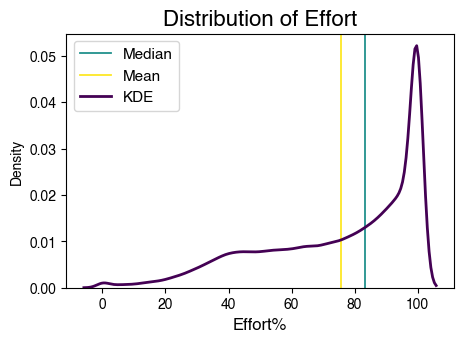

In [255]:
## X. Extra Visualization
plt.figure(figsize=(5,3.3))
plt.title('Distribution of Effort', fontsize=16)
plt.xlabel('Effort%', fontsize=12)
plt.ylabel('Density', fontsize=10)
plt.axvline(x=median_effort, linestyle='-', lw=1.3, color=colors[1], alpha=1, label='Median')
plt.axvline(x=mean_effort, linestyle='-', lw=1.3, color=colors[2], alpha=1, label='Mean')
sns.kdeplot(running['effort_percent'], color=colors[0], label='KDE', lw=2)
plt.legend(fontsize=11)

(24.5, 36.5)

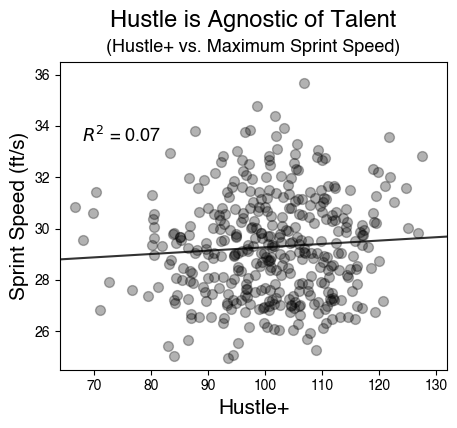

In [258]:
## X. Extra Visualization
from scipy.stats import linregress
# We can see that acc_5to10_95th has little correlation to maximum speed
# But acc_25to30_95th as strong correlation to maximum speed
# Futhermore we can see that they're not correlated to each other
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.figure(figsize=(5,4))
# Left plot
slope, intercept, r, p, se = linregress(filter_3runs['hustle_plus'],filter_3runs['max_speed'])
line_x = np.linspace(60,140,100)
line_y = slope*line_x + intercept
plt.plot(line_x, line_y, color='black', lw=1.5, alpha=0.8)
plt.title('Hustle is Agnostic of Talent', fontsize=17, pad=25)
plt.text(0.113,0.98, '(Hustle+ vs. Maximum Sprint Speed)',transform=ax.transAxes,fontsize=13,va='top')
plt.scatter(filter_3runs['hustle_plus'],filter_3runs['max_speed'], color='black', alpha=0.3, s=50, edgecolor='black', linewidth=1)
plt.text(0.05, 0.73, f'$R^2$ = {r:.2f}',transform=ax.transAxes,fontsize=13,va='top')
plt.xlabel('Hustle+', fontsize=15)
plt.ylabel('Sprint Speed (ft/s)', fontsize=15)
plt.xlim(64,132)
plt.ylim(24.5,36.5)

In [185]:
running

,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm,spd_sm_mapsoft_theta,acc_5to10_95th,effort_percent,hustle_plus,team
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560749,91.276741,5.896027,18.429326,29.039858,23.519888,80.283552,106.245787,CGA
1,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560799,90.981940,6.817493,19.642164,29.039858,23.519888,80.017342,105.893490,CGA
2,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560849,90.641065,7.799601,20.531749,29.039858,23.519888,86.569445,114.564423,CGA
3,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560899,90.251085,8.826189,20.128316,29.039858,23.519888,82.634102,109.356461,CGA
4,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560949,89.809776,9.832604,19.401630,29.039858,23.519888,79.239368,104.863932,CGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328330,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993763,6.721695,28.945442,-0.283495,31.063813,24.280569,75.326322,99.685479,RZQ
328331,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993813,5.274423,28.931267,-0.401357,31.063813,24.280569,74.158764,98.140354,RZQ
328332,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993863,3.827860,28.911199,-0.519218,31.063813,24.280569,70.994119,93.952321,RZQ
328333,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993913,2.382300,28.885238,-0.637080,31.063813,24.280569,69.842533,92.428333,RZQ


In [222]:
teams.head(6).reset_index()

,index,team,team_hustle,team_effort,team_contests
0,73,YJD,99.082584,74.870751,744
1,54,RZQ,106.994603,80.849387,743
2,49,QEA,102.778916,77.663846,276
3,11,DYE,104.768546,79.167290,123
4,44,OXG,95.094074,71.856873,62
5,13,FBP,106.668986,80.603338,40


In [65]:
"""
Export
"""
# Organize
running = running.drop(columns=['acc_25to30_95th','max_acc_cap','lenient_force_percent'])
running['timestamp'] = running['timestamp'].astype('Int64')

# Merge timestamps_before_time_start_running (see above)
running_hustle = pd.concat([running, timestamps_before_time_start_running], axis=0)

# Fill spd_sm_mapsoft_theta and acc_5to10_95th
running_hustle['spd_sm_mapsoft_theta'] = running_hustle.groupby(['batter'])['spd_sm_mapsoft_theta'].transform(lambda x: x.ffill().bfill())
running_hustle['acc_5to10_95th'] = running_hustle.groupby(['batter'])['acc_5to10_95th'].transform(lambda x: x.ffill().bfill())

# Export
running_hustle.to_csv('../CSV/running_hustle.csv', index=False)

running_hustle.sort_values(by=['game_str','play_id','timestamp'])

,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm,spd_sm_mapsoft_theta,acc_5to10_95th,effort_percent,hustle_plus
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,557049,92.498242,-0.095367,-0.172105,29.039858,23.519888,NaN,NaN
1,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,557099,92.503011,-0.103972,-0.148303,29.039858,23.519888,NaN,NaN
2,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,557149,92.508209,-0.111387,-0.124501,29.039858,23.519888,NaN,NaN
3,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,557199,92.513779,-0.117612,-0.100699,29.039858,23.519888,NaN,NaN
4,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,557249,92.519659,-0.122647,-0.076897,29.039858,23.519888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328330,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993763,6.721695,28.945442,-0.283495,31.063813,24.280569,75.326322,99.685479
328331,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993813,5.274423,28.931267,-0.401357,31.063813,24.280569,74.158764,98.140354
328332,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993863,3.827860,28.911199,-0.519218,31.063813,24.280569,70.994119,93.952321
328333,y2_d098_YJD_RZQ,245.0,RZQ-0328,L,8989763.0,8989913.0,150.0,400.0,0.0,8993913,2.382300,28.885238,-0.637080,31.063813,24.280569,69.842533,92.428333
